# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 04.11.2022

Мягкий дедлайн: 23:59MSK 16.11.2022

Жесткий дедлайн: 23:59MSK 23.11.2022

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт один из двух классов с равными вероятностями. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [3]:
np.random.seed(42)

# наш случайный классификатор
y_random = np.random.choice([0, 1], size=len(y_test), p=[0.5, 0.5])
y_random

array([0, 1, 1, ..., 0, 0, 1])

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно, за особенно эффективные или красивые варианты может быть начислен небольшой бонус :)

In [4]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as log_reg
from sklearn.calibration import CalibratedClassifierCV
import seaborn as sns

sns.set(style='darkgrid')

AUC-PR: 0.63340
AUC-ROC: 0.50394


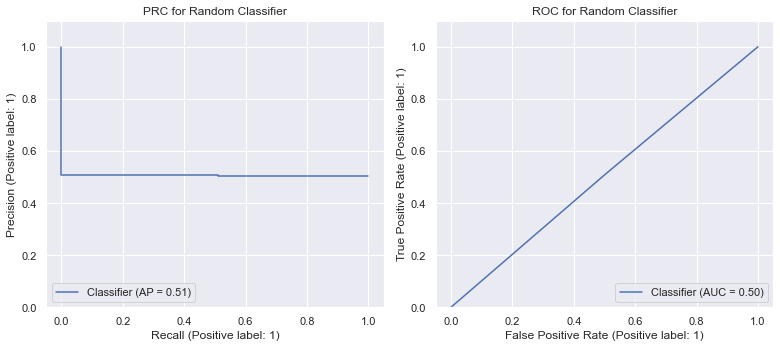

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

PrecisionRecallDisplay.from_predictions(y_test, y_random, ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, y_random)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PRC for Random Classifier")
ax[0].set_ylim(0, 1.1)

RocCurveDisplay.from_predictions(y_test, y_random, ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, y_random))
ax[1].set_title("ROC for Random Classifier")
ax[1].set_ylim(0, 1.1)
plt.tight_layout()

In [6]:
# dataframe для сравнения 
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])

# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
    auc(recall, precision),
    roc_auc_score(y_test, y_random),
    None
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.633402,0.503944,NaN


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).

__NB!__ Здесь и далее, если не сказано иначе, подбирайте __оптимальные гиперпараметры с точки зрения AUC-PR.__

In [7]:
C_list = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]
skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=42)
best_C = {'loss':0, 'C': 0}
for C in C_list:
    auc_iter = []
    for tr, vl in skf.split(X_train, y_train):
        svc = SVC(C=C, kernel='linear')
        svc.fit(X_train[tr], y_train[tr])
        y_pred = svc.predict(X_train[vl])
        precision, recall, _ = precision_recall_curve(y_train[vl], y_pred)
        loss = auc(recall, precision)
        auc_iter.append(loss)
    print(f'AUC-PR for SVC with C = {C}: {np.mean(auc_iter)}')
    if np.mean(auc_iter) > best_C['loss']:
        best_C['C'] = C
        best_C['loss'] = np.mean(auc_iter)

AUC-PR for SVC with C = 0.0001: 0.8284429644757297
AUC-PR for SVC with C = 0.001: 0.8343921062388479
AUC-PR for SVC with C = 0.01: 0.8343392866490712
AUC-PR for SVC with C = 0.1: 0.8348614898798796
AUC-PR for SVC with C = 1: 0.8342165144116083
AUC-PR for SVC with C = 10.0: 0.8344261223456758
AUC-PR for SVC with C = 100.0: 0.8348450269135604
AUC-PR for SVC with C = 1000.0: 0.8344325163106022


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

AUC-PR: 0.81496
AUC-ROC: 0.84792


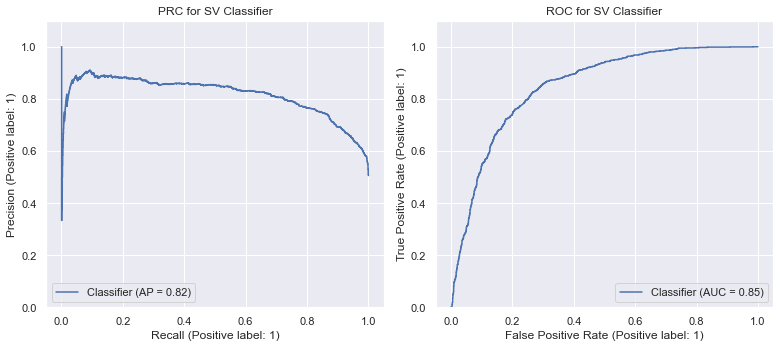

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

svc = SVC(C=0.1, kernel='linear', probability=True)
svc.fit(X_train, y_train)
y_pred = svc.predict_proba(X_test)[:,1]
PrecisionRecallDisplay.from_predictions(y_test, y_pred, ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PRC for SV Classifier")
ax[0].set_ylim(0, 1.1)


RocCurveDisplay.from_predictions(y_test, y_pred, ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, y_pred))
ax[1].set_title("ROC for SV Classifier")
ax[1].set_ylim(0, 1.1)
plt.tight_layout()

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

__Logistic Regression__

Теперь повторите то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление метрик и построение кривых ROC и PR.

In [9]:
C_list = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]
skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=42)
best_C_log = {'loss':0, 'C': 0}
for C in C_list:
    auc_iter = []
    for tr, vl in skf.split(X_train, y_train):
        model = log_reg(C=C)
        model.fit(X_train[tr], y_train[tr])
        y_pred = model.predict(X_train[vl])
        precision, recall, _ = precision_recall_curve(y_train[vl], y_pred)
        loss = auc(recall, precision)
        auc_iter.append(loss)
    print(f'AUC-PR for SVC with C = {C}: {np.mean(auc_iter)}')
    if np.mean(auc_iter) > best_C_log['loss']:
        best_C_log['C'] = C
        best_C_log['loss'] = np.mean(auc_iter)

AUC-PR for SVC with C = 0.0001: 0.8213293733749355
AUC-PR for SVC with C = 0.001: 0.8304699235464394
AUC-PR for SVC with C = 0.01: 0.8329972694453349
AUC-PR for SVC with C = 0.1: 0.8330254287687573
AUC-PR for SVC with C = 1: 0.833027053082029
AUC-PR for SVC with C = 10.0: 0.833027053082029
AUC-PR for SVC with C = 100.0: 0.833027053082029
AUC-PR for SVC with C = 1000.0: 0.833027053082029


In [10]:
C = best_C_log['C']

AUC-PR: 0.82912
AUC-ROC: 0.84787


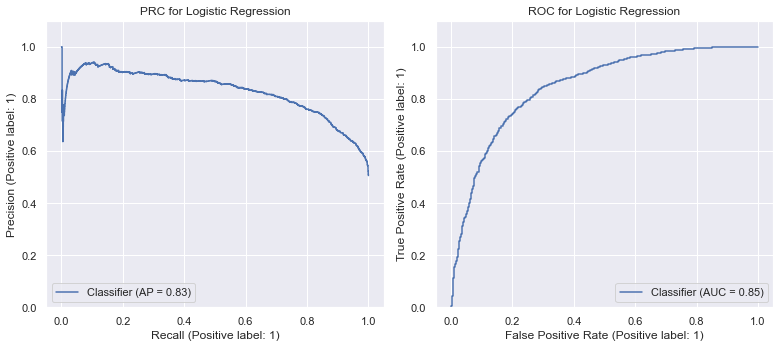

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))

model = log_reg(C=C)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:,1]
PrecisionRecallDisplay.from_predictions(y_test, y_pred, ax=ax[0])
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))
ax[0].set_title("PRC for Logistic Regression")
ax[0].set_ylim(0, 1.1)


RocCurveDisplay.from_predictions(y_test, y_pred, ax=ax[1])
print('AUC-ROC: %.5f' % roc_auc_score(y_test, y_pred))
ax[1].set_title("ROC for Logistic Regression")
ax[1].set_ylim(0, 1.1)
plt.tight_layout()

In [12]:
y_pred

array([0.70878741, 0.01241206, 0.17906374, ..., 0.05981353, 0.86491678,
       0.92855226])

In [13]:
y_random

array([0, 1, 1, ..., 0, 0, 1])

__Микровывод__

  Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

  Ответ: ROC кривые для этих двух методов почти одинаковые. Это значит, что модели одинаково сортируют объекты по вероятностям принадлежности к первому классу. PR кривые также почти одинаковые, однако у логистическоей регрессии  при почти нулевом recall, то есть при близком к единице treshold'е, precision падает сильнее. Precision уменьшает количество False Positive. То есть SVC больше нулевых объектов определил в первый класс с большой уверенностью. Вероятно, это связано с тем, что SVC всегда дает уверенные и неоткалиброванные вероятности, в отличие от логистической регрессии.

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)

В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

1) Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет.

2) Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`). 

In [14]:
X, y = make_classification(
    n_samples=10000, n_features=2,n_informative=2, n_redundant=0, random_state=42)
svc = SVC(kernel='linear')
svc.fit(X,y)


SVC(kernel='linear')

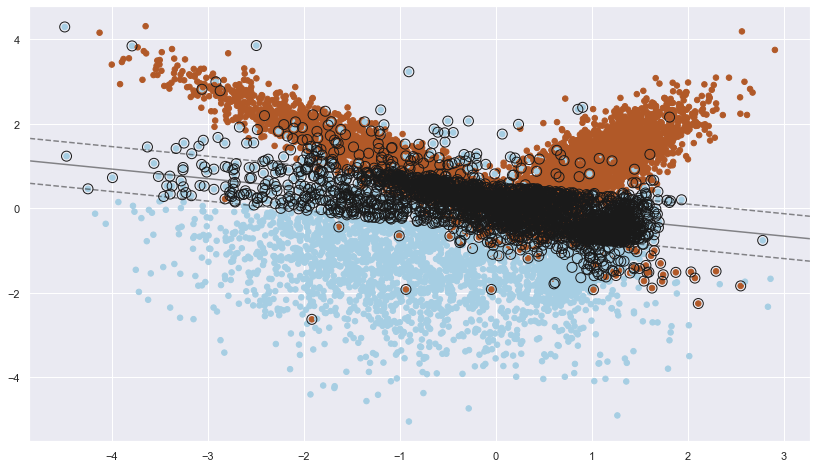

In [15]:
plt.figure(figsize=(14,8))
ax = plt.gca()
plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 100)
yy = np.linspace(ylim[0], ylim[1], 100)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = svc.decision_function(xy).reshape(XX.shape)

ax.contour(XX,
           YY,
           Z,
           colors='k',
           levels=[-1, 0, 1],
           alpha=0.5,
           linestyles=['--', '-', '--'])

ax.scatter(svc.support_vectors_[:, 0],
           svc.support_vectors_[:, 1],
           s=100,
           linewidth=1,
           facecolors='none',
           edgecolors='k')
plt.show()

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor` ([matplotlib demo](https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/pcolor_demo.html#sphx-glr-gallery-images-contours-and-fields-pcolor-demo-py)).

<AxesSubplot:>

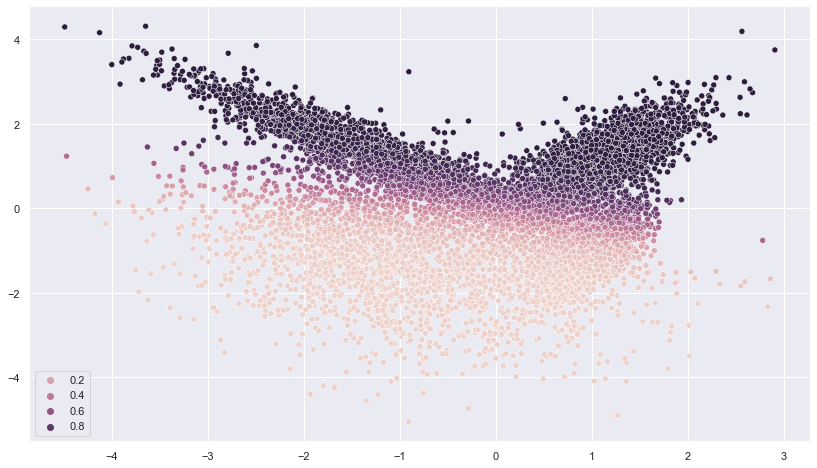

In [16]:
model = log_reg()
model.fit(X,y)
plt.figure(figsize=(14,8))
sns.scatterplot(x=X[:,0], y=X[:,1], hue=model.predict_proba(X)[:,1] )               

#### __Задание 2. Калибровка вероятностей__ (1 балл)

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [17]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = i / n_bins 
        r = (i+1)/ n_bins
        
        bin_middle_points.append(l+(r-l) / 2) 
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1)) 
    
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.plot(np.linspace(0,1,100),np.linspace(0,1,100), '--')
    plt.ylim([-0.05, 1.05])
    plt.xlim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

In [18]:
X,y = make_classification(n_samples=10000, n_features=10, n_informative=7)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

svc = SVC(probability=True)
svc.fit(X_train,y_train)
preds_svc = svc.predict_proba(X_test)[:,1]

log_model = log_reg()
log_model.fit(X_train,y_train)
preds_log = log_model.predict_proba(X_test)[:,1]

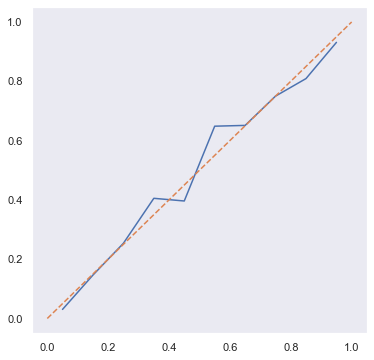

In [19]:
plot_calibration_curve(y_test, preds_log)

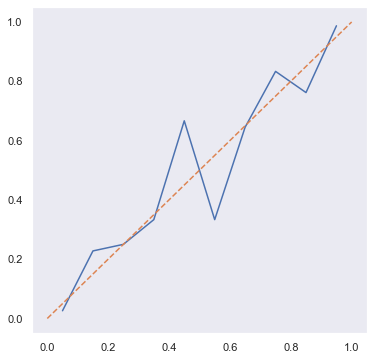

In [20]:
plot_calibration_curve(y_test, preds_svc)

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

Text(0.5, 1.0, 'SVC distribution preds')

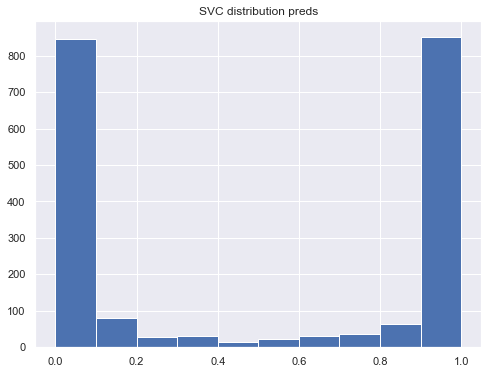

In [21]:
plt.figure(figsize=(8,6))
plt.hist(preds_svc)
plt.title('SVC distribution preds')

Text(0.5, 1.0, 'Log Reg distribution preds')

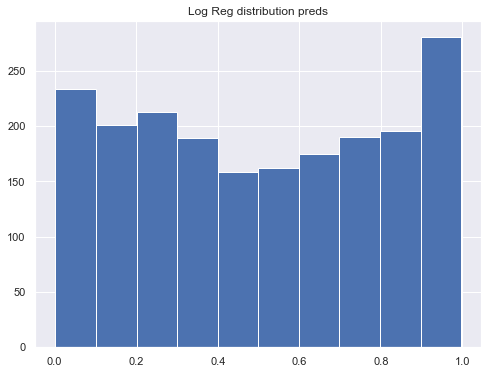

In [22]:
plt.figure(figsize=(8,6))
plt.hist(preds_log)
plt.title('Log Reg distribution preds')


Чем они различаются? Чем вы можете объяснить это?

**Ответ**: Вероятности, выдаваемые SVC, сконцентрированы в точках, близких к единице и нулю, то есть SVC дает более уверенные предсказания. Log Reg дает более равномерное распределение вероятностей, это связано с тем, что логистическая регрессия при увеличении объема выборки будет стремиться выдавать реальные вероятности, то есть модель более откалибрована.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
svc = SVC()
svc.fit(X_train,y_train)
calib = CalibratedClassifierCV(svc, cv='prefit')
calib.fit(X_val,y_val)
preds_calib = calib.predict_proba(X_test)[:,1]

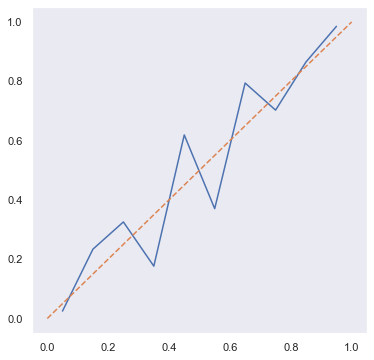

In [24]:
plot_calibration_curve(y_test, preds_calib)

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [25]:
#your code here

# Часть 2. Обработка категориальных переменных

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла. 

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет. 

In [26]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
import timeit

In [27]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain', 
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv(r"C:\Users\Stepan\Desktop\ФКН Домашка\adult.data", header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')

In [28]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. 

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('income', axis=1), df['income'], test_size=0.25)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`, а числовые признаки нормализуйте с помощью `StandardScaler`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [30]:
df.income.value_counts()

0    24720
1     7841
Name: income, dtype: int64

In [31]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income             int32
dtype: object

In [32]:
cat_col = ['workclass','education','marital-status','occupation','relationship', 'race', 'sex', 'native-country']
num_col = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

In [33]:
start_time = timeit.default_timer()
encoder = OrdinalEncoder()
X_train[cat_col] = encoder.fit_transform(X_train[cat_col])
X_test[cat_col] = encoder.transform(X_test[cat_col])

scaler = StandardScaler()
X_train[num_col] = scaler.fit_transform(X_train[num_col])
X_test[num_col] = scaler.transform(X_test[num_col])

model = log_reg(max_iter=1000)

model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))

end_time = timeit.default_timer()
print(f'Amount of time: {end_time-start_time}')

AUC-PR: 0.68815
Amount of time: 0.27902100000005703


__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ответ__: Классы, которые мы предсказываем, несбалансированы. AUC ROC может давать ложные оптимистичные значения, т.к. наша модель может хорошо обучиться на классе большинства и плохо на классе меньшиства. AUC PR позволит рассмотреть качество предсказания на 1 классе, который в меньшистве.

#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [34]:
start_time = timeit.default_timer()

X_train = X_train.drop(columns=cat_col).join(pd.get_dummies(X_train[cat_col]).astype('str'))
X_test = X_test.drop(columns=cat_col).join(pd.get_dummies(X_test[cat_col]).astype('str'))
#X_test['native-country_15.0'] = 0

model = log_reg(max_iter=1000)

model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))

end_time = timeit.default_timer()
print(f'Amount of time: {end_time-start_time}')

AUC-PR: 0.68813
Amount of time: 0.4242099999999027


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('income', axis=1), df['income'], test_size=0.25)

scaler = StandardScaler()
X_train[num_col] = scaler.fit_transform(X_train[num_col])
X_test[num_col] = scaler.transform(X_test[num_col])

In [36]:
class MeanTarget():
    
    def __init__(self, cat_col):
        self.cat_col = cat_col
        
        
    def fit(self,X, y):
        X = X.copy()
        self.dict_cat = {}
        self.mean_y = np.mean(y)
        
        for column_name in self.cat_col:
            self.dict_cat[column_name] = {}
            for category in X[column_name].unique():
                self.dict_cat[column_name][category] = np.mean(y[X.loc[X[column_name]==category].index])
                
    def transform(self, X):
        X = X.copy()
        for column_name in self.cat_col:
            for category in X[column_name].unique():
                X.loc[X[column_name]==category, column_name] = self.dict_cat.get(column_name).get(category, self.mean_y)
        return X
        
    def fit_transform(self, X, y):
        self.fit(X,y)
        return self.transform(X)


In [37]:
start_time = timeit.default_timer()

mte = MeanTarget(cat_col)
X_train = mte.fit_transform(X_train, y_train)
X_test = mte.transform(X_test)

model = log_reg(max_iter=1000, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))

end_time = timeit.default_timer()
print(f'Amount of time: {end_time-start_time}')

AUC-PR: 0.76662
Amount of time: 4.489578599999959


##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их. 

In [ ]:
class TargetEncoderCV(BaseEstimator, TransformerMixin):

    def __init__(self, cv, cbe_params):
        self.cv = cv
        self.cbe_params = cbe_params

    @property
    def _n_splits(self):
        return check_cv(self.cv).n_splits

    def fit_transform(self, X: pd.DataFrame, y) -> pd.DataFrame:
        self.cbe_ = []
        cv = check_cv(self.cv)

        cbe = CatBoostEncoder(
            cols=X.columns.tolist(),
            return_df=False,
            **self.cbe_params
        )

        X_transformed = np.zeros_like(X, dtype=np.float64)
        for train_idx, valid_idx in cv.split(X, y):
            self.cbe_.append(
                clone(cbe).fit(X.iloc[train_idx], y.iloc[train_idx])
            )
            X_transformed[valid_idx] = self.cbe_[-1].transform(
                X.iloc[valid_idx]
            )

        return pd.DataFrame(X_transformed, columns=X.columns)

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X_transformed = np.zeros_like(X, dtype=np.float64)
        X_transformed=np.vstack(X_transformed)
        for cbe in self.cbe_:
            X_transformed += cbe.transform(X) / self._n_splits
        return pd.DataFrame(X_transformed, columns=X.columns)

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

In [38]:
class MeanTargetNoise():    
    def __init__(self, cat_col):
        self.cat_col = cat_col
        
        
    def fit(self,X, y):
        X = X.copy()
        self.dict_cat = {}
        self.mean_y = np.mean(y)
        
        for column_name in self.cat_col:
            self.dict_cat[column_name] = {}
            for category in X[column_name].unique():
                
                cat_mean = np.mean(y[X.loc[X[column_name]==category].index])
                self.dict_cat[column_name][category] = cat_mean
                
    def transform(self, X):
        X = X.copy()
        np.random.seed(42)
        for column_name in self.cat_col:
            for category in X[column_name].unique():
                len_ = X.loc[X[column_name]==category]
                cat_mean = self.dict_cat.get(column_name).get(category, self.mean_y)
                X.loc[X[column_name]==category, column_name] = cat_mean + np.random.uniform(-0.06,0.06)
        return X
        
    def fit_transform(self, X, y):
        self.fit(X,y)
        return self.transform(X)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('income', axis=1), df['income'], test_size=0.25)

scaler = StandardScaler()
X_train[num_col] = scaler.fit_transform(X_train[num_col])
X_test[num_col] = scaler.transform(X_test[num_col])

In [40]:
start_time = timeit.default_timer()

mte = MeanTargetNoise(cat_col)
X_train = mte.fit_transform(X_train, y_train)
X_test = mte.transform(X_test)

model = log_reg(max_iter=1000, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))

end_time = timeit.default_timer()
print(f'Amount of time: {end_time-start_time}')

AUC-PR: 0.75314
Amount of time: 8.067559400000164


##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [41]:
#your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты.


In [42]:
class MeanTargetSmooth():    
    def __init__(self, cat_col, C):
        self.cat_col = cat_col
        self.C = C
        
    def fit(self,X, y):
        X = X.copy()
        self.dict_cat = {}
        self.mean_y = np.mean(y)
        
        for column_name in self.cat_col:
            self.dict_cat[column_name] = {}
            for category in X[column_name].unique():
                len_ = X.loc[X[column_name]==category].shape[0]
                cat_mean = (np.sum(y[X.loc[X[column_name]==category].index]) + self.C * self.mean_y) / (len_ + self.C)
                self.dict_cat[column_name][category] = cat_mean
                
    def transform(self, X):
        X = X.copy()
        
        for column_name in self.cat_col:
            for category in X[column_name].unique():
                cat_mean = self.dict_cat.get(column_name).get(category, self.mean_y)
                X.loc[X[column_name]==category, column_name] = cat_mean 
        return X
        
    def fit_transform(self, X, y):
        self.fit(X,y)
        return self.transform(X)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('income', axis=1), df['income'], test_size=0.25)

scaler = StandardScaler()
X_train[num_col] = scaler.fit_transform(X_train[num_col])
X_test[num_col] = scaler.transform(X_test[num_col])

In [44]:
start_time = timeit.default_timer()

mte = MeanTargetSmooth(cat_col, 10)
X_train = mte.fit_transform(X_train, y_train)
X_test = mte.transform(X_test)

model = log_reg(max_iter=1000, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
print('AUC-PR: %.5f' % auc(recall, precision))

end_time = timeit.default_timer()
print(f'Amount of time: {end_time-start_time}')

AUC-PR: 0.77167
Amount of time: 5.0761903000000075


#### __Задание 8. И все-таки числовой?__  (0.5 балла)

В данных имеются признаки "возраст" и "число рабочих часов в неделю". Сейчас мы интерпретируем их как числовые, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?



In [45]:
candidat_cat = ['hours-per-week', 'age',['hours-per-week', 'age']]

for candidat in candidat_cat:
    if type(candidat) != list:
        candidat = [candidat]
        
    mte = MeanTargetSmooth(candidat, 10)
    X_train_try = mte.fit_transform(X_train, y_train)
    X_test_try = mte.transform(X_test)
    
    model = log_reg(max_iter=1000, random_state=42)
    model.fit(X_train_try, y_train)
    y_pred = model.predict_proba(X_test_try)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    print(f'--{candidat}--')
    print('AUC-PR: %.5f' % auc(recall, precision))

    end_time = timeit.default_timer()
    print(f'Amount of time: {end_time-start_time}')
    

--['hours-per-week']--
AUC-PR: 0.77331
Amount of time: 5.368485200000123
--['age']--
AUC-PR: 0.78008
Amount of time: 5.655146000000059
--['hours-per-week', 'age']--
AUC-PR: 0.78126
Amount of time: 6.070082599999978


> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ Плюсы mte заключаются в уменьшении размерности. Качество получается лучше, чем у label кодирования. При правильной настройке параметров для борьбы с переобучением mte, за счет меньшего количества обучаемых параметров(весов модели) может переобучаться меньше, чем one hot, особенно если присутствуют редкие категории. Минусы заключаются в том, что mte также склонно к переобучению, а методы борьбы нужно настраивать, чтобы признак не потерял своего смысла. На более сложных моделях mte будет вероятно работать лучше, чем остальные методы, в частности one-hot.

# Часть 3. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тем же данным про предсказание дохода.

In [46]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain', 
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv(r"C:\Users\Stepan\Desktop\ФКН Домашка\adult.data", header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')

Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. 

In [47]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('income', axis=1), 
                                                    df['income'], test_size=0.25, stratify=df['income'])

scaler = StandardScaler()
X_train[num_col] = scaler.fit_transform(X_train[num_col])
X_test[num_col] = scaler.transform(X_test[num_col])

In [48]:
cat_col = ['workclass', 'education', 'marital-status', 'occupation',
     'relationship',
     'race',
     'sex',
     'native-country',
           'hours-per-week',
           'age'
]

Давайте закодируем все категориальные признаки с помощью One-hot Encoding, считая возраст и число часов числовыми. Сколько новых признаков мы получим?

In [49]:
ohe = OneHotEncoder(handle_unknown='ignore')
X_train.index = range(X_train.shape[0])
X_test.index = range(X_test.shape[0])
X_train_ohe = X_train.drop(columns=cat_col).join(pd.DataFrame(ohe.fit_transform(X_train[cat_col]).toarray(),index = X_train.index) )
X_test_ohe = X_test.drop(columns=cat_col).join(pd.DataFrame(ohe.transform(X_test[cat_col]).toarray(),index = X_test.index))
print(f'Amount of new features: {X_train_ohe.shape[1] - X_train.shape[1]}')

Amount of new features: 258


In [50]:
X_train_ohe.columns = X_train_ohe.columns.astype(str)
X_test_ohe.columns = X_test_ohe.columns.astype(str)

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [51]:
model = log_reg(max_iter=1000, random_state=777)

model.fit(X_train_ohe, y_train)
y_pred = model.predict_proba(X_test_ohe)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc_ohe = auc(recall, precision)
print('AUC-PR: %.6f' % auc_ohe)

AUC-PR: 0.786674


#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [52]:
coefficients = list(enumerate(abs(model.coef_)[0]))
coefficients.sort(key=lambda x: x[1], reverse=True)
good_feat = [i[0] for i in coefficients[:40]]

In [53]:
good_feat[:12]

[2, 202, 200, 108, 203, 30, 201, 31, 56, 205, 161, 154]

In [54]:
X_train_ohe_elim = X_train_ohe.iloc[:,good_feat]
X_test_ohe_elim = X_test_ohe.iloc[:,good_feat]

In [55]:
X_train_ohe_elim.head(3)

,capital-gain,198,196,104,199,26,197,27,52,201,157,150,41,22,200,195,202,180,181,116,37,167,124,36,126,64,231,232,29,204,177,228,175,225,237,258,45,230,203,66
0,-0.145957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.769882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.145957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
model = log_reg(max_iter=1000, random_state=777)

model.fit(X_train_ohe_elim, y_train)
y_pred = model.predict_proba(X_test_ohe_elim)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc_ohe = auc(recall, precision)
print('AUC-PR: %.6f' % auc_ohe)

AUC-PR: 0.680977


Изменилось ли качество? Как?

**Ответ:** Качество ухудшилось

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [57]:
scaler = StandardScaler()
X_train_ohe = pd.DataFrame(scaler.fit_transform(X_train_ohe), columns=X_train_ohe.columns, index=X_train_ohe.index)
X_test_ohe = pd.DataFrame(scaler.transform(X_test_ohe), columns=X_train_ohe.columns, index=X_test_ohe.index)

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [58]:
model = log_reg(max_iter=1000, random_state=777)

model.fit(X_train_ohe, y_train)

LogisticRegression(max_iter=1000, random_state=777)

In [59]:
coefficients = list(enumerate(abs(model.coef_)[0]))
coefficients.sort(key=lambda x: x[1], reverse=True)
good_feat = [i[0] for i in coefficients[:40]]

In [60]:
good_feat[:12]

[2, 202, 200, 199, 31, 26, 33, 1, 201, 56, 29, 203]

In [61]:
X_train_ohe_elim = X_train_ohe.iloc[:,good_feat]
X_test_ohe_elim = X_test_ohe.iloc[:,good_feat]

In [62]:
X_train_ohe_elim.head(3)

,capital-gain,198,196,195,27,22,29,education-num,197,52,25,199,41,capital-loss,40,36,58,59,50,124,37,225,42,151,201,228,218,223,121,258,222,231,226,126,224,215,232,230,131,229
0,-0.145957,-0.152076,-0.133246,-0.111148,-0.920891,-0.041999,-0.698589,-0.035734,-0.150234,-0.222306,-0.398533,-0.150519,-0.06665,3.950793,-0.336283,2.666003,1.425362,-1.425362,-0.431626,-0.02716,-0.180922,-0.149663,-0.382866,-0.307214,-0.167314,-0.137016,-0.159522,-0.154038,-0.197973,-0.026394,-0.150091,-0.121803,7.662023,-0.145462,-0.15306,-0.163129,-0.114131,-0.123694,-0.187107,-0.1353
1,1.769882,-0.152076,-0.133246,-0.111148,-0.920891,-0.041999,1.431457,-0.422880,-0.150234,-0.222306,-0.398533,-0.150519,-0.06665,-0.215689,-0.336283,-0.375093,1.425362,-1.425362,-0.431626,-0.02716,-0.180922,-0.149663,-0.382866,-0.307214,-0.167314,-0.137016,-0.159522,-0.154038,-0.197973,-0.026394,-0.150091,-0.121803,-0.130514,-0.145462,-0.15306,6.130106,-0.114131,-0.123694,-0.187107,-0.1353
2,-0.145957,-0.152076,-0.133246,-0.111148,-0.920891,-0.041999,-0.698589,1.125705,-0.150234,-0.222306,-0.398533,-0.150519,-0.06665,-0.215689,-0.336283,-0.375093,1.425362,-1.425362,-0.431626,-0.02716,-0.180922,-0.149663,2.611878,-0.307214,-0.167314,-0.137016,-0.159522,-0.154038,-0.197973,-0.026394,-0.150091,-0.121803,-0.130514,-0.145462,-0.15306,-0.163129,-0.114131,-0.123694,-0.187107,-0.1353


In [63]:
model = log_reg(max_iter=1000, random_state=777)

model.fit(X_train_ohe_elim, y_train)
y_pred = model.predict_proba(X_test_ohe_elim)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc_ohe = auc(recall, precision)
print('AUC-PR: %.6f' % auc_ohe)

AUC-PR: 0.766124


#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [64]:
def t_value(df,  target_name):
    X_plus = df.loc[df[target_name] == 1].drop(columns=target_name)
    X_minus = df.loc[df[target_name] == 0].drop(columns=target_name)
    
    X_plus_std = X_plus.describe().loc['std']
    X_minus_std = X_minus.describe().loc['std']
    
    X_plus_mean = X_plus.describe().loc['mean']
    X_minus_mean = X_minus.describe().loc['mean']
    
    X_plus_n = X_plus.describe().loc['count']
    X_minus_n = X_minus.describe().loc['count']
    
    columns = X_plus.columns.to_list()
    
    t_values = abs(X_plus_mean - X_minus_mean)/np.sqrt((X_plus_n*X_plus_std**2 +X_minus_n*X_minus_std**2)/(X_plus_n+X_minus_n))
    return list(zip(columns, t_values))

In [65]:
y_train.index = range(len(y_train))
df_train_ohe = X_train_ohe.join(y_train)
t_values = sorted(t_value(df_train_ohe, 'income'), key=lambda x: x[1], reverse = True)[:40]
good_feats_t = [i[0] for i in t_values] 
good_feats_t[:9]

['27', '47', 'education-num', '29', '50', 'capital-gain', '58', '59', '36']

In [66]:
X_train_ohe_t = X_train_ohe.loc[:,good_feats_t]
X_test_ohe_t = X_test_ohe.loc[:,good_feats_t]

In [67]:
model = log_reg(max_iter=1000, random_state=777)

model.fit(X_train_ohe_t, y_train)
y_pred = model.predict_proba(X_test_ohe_t)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc_ohe = auc(recall, precision)
print('AUC-PR: %.6f' % auc_ohe)

AUC-PR: 0.764289


#### __Задание 11. Методы-обёртки__ (1 балл) 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [74]:
X_train_ohe, X_val_ohe, y_train, y_val = train_test_split(X_train_ohe, y_train, test_size=0.25)

k = X_train_ohe.shape[1]
feat_to_drop = []

while k != 40:
    feat_imp = []
    
    for i in set(X_train_ohe.columns) - set(feat_to_drop):
        
        X_time = X_train_ohe.drop([i]+feat_to_drop, axis=1)
        model = log_reg(max_iter=1000)
        model.fit(X_time, y_train)
        y_pred = model.predict_proba(X_val_ohe.drop([i]+feat_to_drop, axis=1))[:,1]
        precision, recall, _ = precision_recall_curve(y_val, y_pred)
        auc_iter = auc(recall, precision)
        feat_imp.append([i, auc_iter])
        
    max_ = max(feat_imp, key=lambda x: x[1])
    feat_to_drop.append(max_[0])
    print(f'We drop {max_[0]} and get AUC-PR {max_[1]:.5f}')
    k -= 1

We drop 160 and get AUC-PR 0.73530
We drop 152 and get AUC-PR 0.73668
We drop 261 and get AUC-PR 0.73806
We drop 133 and get AUC-PR 0.73889
We drop 170 and get AUC-PR 0.74166
We drop 177 and get AUC-PR 0.74305
We drop 150 and get AUC-PR 0.74373
We drop 111 and get AUC-PR 0.74439
We drop 257 and get AUC-PR 0.74490
We drop 231 and get AUC-PR 0.74556
We drop 221 and get AUC-PR 0.74633
We drop 77 and get AUC-PR 0.74675
We drop 81 and get AUC-PR 0.74845
We drop 79 and get AUC-PR 0.74921
We drop 99 and get AUC-PR 0.75041
We drop 66 and get AUC-PR 0.75111
We drop 80 and get AUC-PR 0.75193
We drop 219 and get AUC-PR 0.75236
We drop 128 and get AUC-PR 0.75291
We drop 156 and get AUC-PR 0.75369
We drop 96 and get AUC-PR 0.75435
We drop 143 and get AUC-PR 0.75492
We drop 62 and get AUC-PR 0.75539
We drop 78 and get AUC-PR 0.75588
We drop 159 and get AUC-PR 0.75617
We drop 87 and get AUC-PR 0.75655
We drop 220 and get AUC-PR 0.75685
We drop 110 and get AUC-PR 0.75710
We drop 171 and get AUC-PR 0.7

In [79]:
feat_to_drop[:7]

['160', '152', '261', '133', '170', '177', '150']

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [81]:
k = 0
good_feats = []

while k != 40:
    feat_imp = []
    
    for i in set(X_train_ohe.columns) - set(good_feats):
        
        X_time = X_train_ohe.drop([i]+good_feats, axis=1)
        model = log_reg(max_iter=1000)
        model.fit(X_time, y_train)
        y_pred = model.predict_proba(X_val_ohe.drop([i]+good_feats, axis=1))[:,1]
        precision, recall, _ = precision_recall_curve(y_val, y_pred)
        auc_iter = auc(recall, precision)
        feat_imp.append([i, auc_iter])
        
    min_ = min(feat_imp, key=lambda x: x[1])
    good_feats.append(min_[0])
    print(f'We add {min_[0]} and get AUC-PR when delete it {min_[1]:.5f}')
    k += 1

We add capital-gain and get AUC-PR when delete it 0.68377
We add capital-loss and get AUC-PR when delete it 0.67686
We add fnlwgt and get AUC-PR when delete it 0.67448
We add 180 and get AUC-PR when delete it 0.67282
We add 175 and get AUC-PR when delete it 0.67070
We add 108 and get AUC-PR when delete it 0.66997
We add 181 and get AUC-PR when delete it 0.66955
We add 81 and get AUC-PR when delete it 0.66909
We add 126 and get AUC-PR when delete it 0.66820
We add 166 and get AUC-PR when delete it 0.66465
We add 151 and get AUC-PR when delete it 0.66449
We add 141 and get AUC-PR when delete it 0.65859
We add 131 and get AUC-PR when delete it 0.65735
We add 120 and get AUC-PR when delete it 0.65582
We add 117 and get AUC-PR when delete it 0.65534
We add 125 and get AUC-PR when delete it 0.65444
We add 155 and get AUC-PR when delete it 0.65441
We add 1 and get AUC-PR when delete it 0.65381
We add 6 and get AUC-PR when delete it 0.65256
We add 4 and get AUC-PR when delete it 0.64897
We add

In [84]:
X_train_ohe_e = X_train_ohe.loc[:,good_feats]
X_test_ohe_e = X_test_ohe.loc[:,good_feats]

In [85]:
model = log_reg(max_iter=1000, random_state=777)

model.fit(X_train_ohe_e, y_train)
y_pred = model.predict_proba(X_test_ohe_e)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc_ohe = auc(recall, precision)
print('AUC-PR: %.6f' % auc_ohe)

AUC-PR: 0.583211


Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** Самым лучшим методом оказался метод-обертки по жадному удалению самых худших признаков на каждой итерации, самим плохим метод обертки с постепенным добавлением самых лучших признаков на каждой итерации. Методы обертки очень долгие методы и качество получилось чуть лучше, чем при отборе, используя t значение. Встроенные методы также работают хорошо, если отнормировать все признаки, включая категориальные.

# Часть 4. Оценка экономического эффекта модели

> В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: 
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

> Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [200]:
from sklearn.metrics import precision_score as precision, recall_score as recall

In [117]:
df = pd.read_csv(r"C:\Users\Stepan\Desktop\ФКН Домашка\bank-additional-full.csv", sep=';')

In [118]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [119]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [120]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=500)

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [121]:
cat_col = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week',
          'poutcome']
num_col = [ 'campaign', 'pdays', 'previous', 'emp.var.rate','cons.price.idx', 'cons.conf.idx',
           'euribor3m', 'nr.employed']
scaler = StandardScaler()
X[num_col] = scaler.fit_transform(X[num_col])
ohe = OneHotEncoder(handle_unknown='ignore')
X.index = range(X.shape[0])
X_ohe = X.drop(columns=cat_col).join(pd.DataFrame(ohe.fit_transform(X[cat_col]).toarray(),index = X.index) )

In [122]:
X_ohe.columns = X_ohe.columns.astype('str')

In [123]:
for tr, vl in skf.split(X, y):
    model = log_reg(max_iter=1000)
    model.fit(X_ohe.iloc[tr], y.iloc[tr])
    y_pred = model.predict_proba(X_ohe.iloc[vl])[:,1]
    precision, recall, _ = precision_recall_curve(y.iloc[vl], y_pred)
    auc_fold = auc(recall, precision)
    
    print(f'AUC-PR for some fold: {auc_fold:.5f}')

AUC-PR for some fold: 0.45187
AUC-PR for some fold: 0.44537
AUC-PR for some fold: 0.40957
AUC-PR for some fold: 0.46782
AUC-PR for some fold: 0.45367


Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете? 
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [143]:
good_preds = []

for tr, vl in skf.split(X, y):
    model = log_reg(max_iter=1000)
    model.fit(X_ohe.iloc[tr], y.iloc[tr])
    y_pred = model.predict(X_ohe.iloc[vl])
    
    good_pred = (y_pred*y.iloc[vl]).sum()
    good_preds.append(good_pred)
    #print(f'Операторы позвонят: {y_pred.sum()}, количество верно угаданных: {good_pred}')
    print(f'Банк заплатит операторам: {y_pred.sum()}, банк заработает: {good_pred*10}')
print(f'STD для выручки: {np.std(good_preds)*10}, средняя выручка: {np.mean(good_preds)*10}')  

Банк заплатит операторам: 326, банк заработает: 2150
Банк заплатит операторам: 345, банк заработает: 2210
Банк заплатит операторам: 311, банк заработает: 1780
Банк заплатит операторам: 361, банк заработает: 2360
Банк заплатит операторам: 351, банк заработает: 2260
STD для выручки: 198.33305322109072, средняя выручка: 2152.0


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [155]:
good_preds = []

for tr, vl in skf.split(X, y):
    model = log_reg(max_iter=1000)
    model.fit(X_ohe.iloc[tr], y.iloc[tr])
    y_pred = model.predict(X_ohe.iloc[vl])
    
    good_pred = (y_pred*y.iloc[vl]).sum()
    #print(precision(y.iloc[vl], y_pred), len(y_pred[y_pred==1]), good_pred)
    tax = np.random.uniform(0,19.9, size=good_pred)
    good_preds.append(tax.sum()-y_pred.sum())
    
    #print(f'Операторы позвонят: {y_pred.sum()}, количество верно угаданных: {good_pred}')
    print(f'Банк заплатит операторам: {y_pred.sum()}, выручка банка: {tax.sum()}')
print(f'STD для выручки: {np.std(good_preds)}, средняя выручка: {np.mean(good_preds)}')  

Банк заплатит операторам: 326, банк заработает: 2156.983193094641
Банк заплатит операторам: 345, банк заработает: 2009.8887812163814
Банк заплатит операторам: 311, банк заработает: 1781.5080238242922
Банк заплатит операторам: 361, банк заработает: 2366.1637626278707
Банк заплатит операторам: 351, банк заработает: 2135.0685406361
STD для выручки: 192.02573888869895, средняя выручка: 2089.9224602798577


Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [188]:
C_list = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]
std_list = []
mean_list = []

for C in C_list:
    good_preds = []
    for tr, vl in skf.split(X, y):
        model = log_reg(C=C, max_iter=10000)
        model.fit(X_ohe.iloc[tr], y.iloc[tr])
        y_pred = model.predict(X_ohe.iloc[vl])

        good_pred = (y_pred*y.iloc[vl]).sum()
        #print(precision(y.iloc[vl], y_pred), len(y_pred[y_pred==1]), good_pred)
        tax = np.random.uniform(0,19.9, size=good_pred)
        good_preds.append(tax.sum()-y_pred.sum())

        #print(f'Операторы позвонят: {y_pred.sum()}, количество верно угаданных: {good_pred}')
       # print(f'Банк заплатит операторам: {y_pred.sum()}, банк заработает: {tax.sum()}')
    print(f'STD для выручки: {np.std(good_preds)}, средняя выручка: {np.mean(good_preds)}, C = {C}')  
    std_list.append(np.std(good_preds))
    mean_list.append(np.mean(good_preds))


STD для выручки: 35.805273169706936, средняя выручка: 59.485373865287855, C = 0.0001
STD для выручки: 89.44697766916875, средняя выручка: 1502.2210974460445, C = 0.001
STD для выручки: 168.16362190563538, средняя выручка: 1622.7238745977675, C = 0.01
STD для выручки: 125.74196493561055, средняя выручка: 1781.3439027700988, C = 0.1
STD для выручки: 105.38116921954418, средняя выручка: 1768.2744950475571, C = 1
STD для выручки: 202.09083727334968, средняя выручка: 1874.1758886238727, C = 10.0
STD для выручки: 159.88110893331793, средняя выручка: 1766.8937555059952, C = 100.0
STD для выручки: 173.21137128705905, средняя выручка: 1787.0602016337223, C = 1000.0


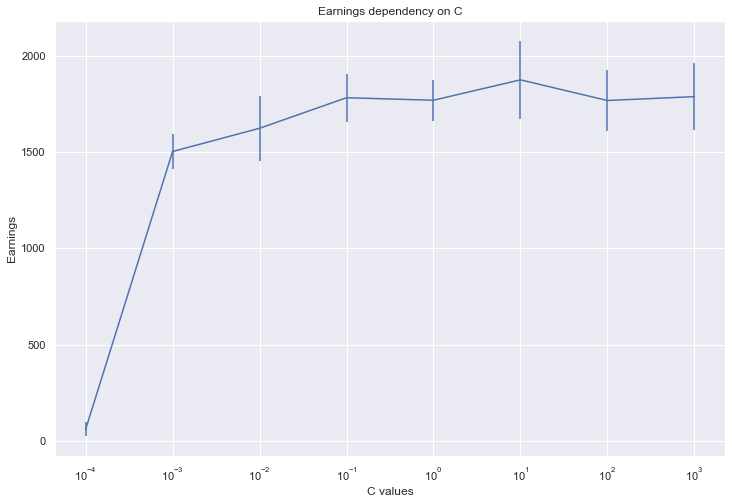

In [189]:
plt.figure(figsize=(12,8))
plt.xscale('log')
plt.errorbar(x=C_list, y=mean_list, yerr=std_list)
plt.title('Earnings dependency on C')
plt.ylabel('Earnings')
plt.xlabel('C values')
plt.show()

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [190]:
for _ in range(5):   
    std_list = []
    mean_list = []

    for C in C_list:
        good_preds = []
        for tr, vl in skf.split(X, y):
            model = log_reg(C=C, max_iter=10000)
            model.fit(X_ohe.iloc[tr], y.iloc[tr])
            y_pred = model.predict(X_ohe.iloc[vl])

            good_pred = (y_pred*y.iloc[vl]).sum()
            #print(precision(y.iloc[vl], y_pred), len(y_pred[y_pred==1]), good_pred)
            tax = np.random.uniform(0,19.9, size=good_pred)
            good_preds.append(tax.sum()-y_pred.sum())

            #print(f'Операторы позвонят: {y_pred.sum()}, количество верно угаданных: {good_pred}')
           # print(f'Банк заплатит операторам: {y_pred.sum()}, банк заработает: {tax.sum()}')
        #print(f'STD для выручки: {np.std(good_preds)}, средняя выручка: {np.mean(good_preds)}, C = {C}')  
        std_list.append(np.std(good_preds))
        mean_list.append(np.mean(good_preds))
    print('Best C = ', max(zip(mean_list, C_list), key=lambda x: x[0])[1])

Best C =  10.0
Best C =  10.0
Best C =  10.0
Best C =  1
Best C =  1000.0


#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__  Наша цель не переплачивать сотрудникам за FP, то есть за ложные звонки, то есть увеличить precision. precision = $\frac {TP}{TP+FP}$. Однако, учитывая разность в зарплате сотрудникам и возможную выгоду с клиента, вероятно выгоднее увеличить в сумме количество клиентов, с которых банк заработает, при этом затраты на сотрудников могут быть незначитаельны в сравнении. То есть увеличивая recall. recall = $\frac{TP}{TP+FN}$


> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [198]:
tresholds = np.linspace(0,1,101)
std_list = []
mean_list = []
for treshold in tresholds:

    good_preds = []
    for tr, vl in skf.split(X, y):
        model = log_reg( C=10, max_iter=10000)
        model.fit(X_ohe.iloc[tr], y.iloc[tr])
        y_pred = model.predict_proba(X_ohe.iloc[vl])[:,1]
        y_pred[y_pred>treshold] = True
        y_pred[y_pred<treshold] = False
        #print(y_pred)
        good_pred = (y_pred*y.iloc[vl]).sum()
        
        #print(good_pred, y.iloc[vl].value_counts())
        #print(precision(y.iloc[vl], y_pred), len(y_pred[y_pred==1]), good_pred)
        tax = np.random.uniform(0,19.9, size=int(good_pred))
        good_preds.append(tax.sum()-y_pred.sum())
        
        #print(good_preds)
        #print(f'Операторы позвонят: {y_pred.sum()}, количество верно угаданных: {good_pred}')
       # print(f'Банк заплатит операторам: {y_pred.sum()}, банк заработает: {tax.sum()}')
    
    print(f'STD для выручки: {np.std(good_preds)}, средняя выручка: {np.mean(good_preds)}, treshold = {treshold}')  
    std_list.append(np.std(good_preds))
    mean_list.append(np.mean(good_preds))

STD для выручки: 157.8689347430312, средняя выручка: 912.5847650394877, treshold = 0.0
STD для выручки: 139.61570174378122, средняя выручка: 1057.089005994548, treshold = 0.01
STD для выручки: 51.91013310072657, средняя выручка: 1207.5280519765442, treshold = 0.02
STD для выручки: 118.2940582246108, средняя выручка: 1555.4753877254766, treshold = 0.03
STD для выручки: 113.68236889791156, средняя выручка: 2287.763309220972, treshold = 0.04
STD для выручки: 133.09696150633252, средняя выручка: 2972.9074166142696, treshold = 0.05
STD для выручки: 150.70436263878855, средняя выручка: 3583.32727695222, treshold = 0.06
STD для выручки: 114.00435921649786, средняя выручка: 3798.210238817056, treshold = 0.07
STD для выручки: 179.27761147476386, средняя выручка: 4059.1085313644858, treshold = 0.08
STD для выручки: 190.913666778354, средняя выручка: 4078.9413349647134, treshold = 0.09
STD для выручки: 164.46969668238538, средняя выручка: 4162.759026378235, treshold = 0.1
STD для выручки: 218.797

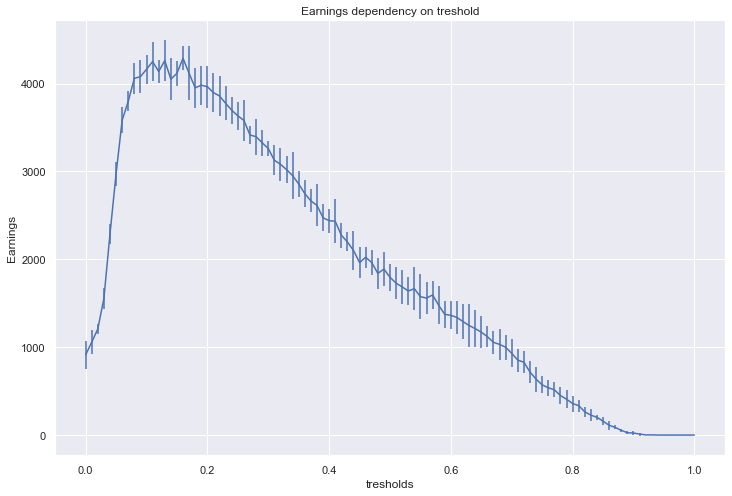

In [199]:
plt.figure(figsize=(12,8))

plt.errorbar(x=tresholds, y=mean_list, yerr=std_list)
plt.title('Earnings dependency on treshold')
plt.ylabel('Earnings')
plt.xlabel('tresholds')
plt.show()

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог. 


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

**Ответ**: Выгоднее увеличивать recall, т.к. максимальная выгода получена при маленьком пороге.

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [204]:
precisions = []
recalls = []
for tr, vl in skf.split(X, y):
    model = log_reg(C=10, max_iter=1000)
    model.fit(X_ohe.iloc[tr], y.iloc[tr])
    y_pred = model.predict_proba(X_ohe.iloc[vl])[:,1]
    y_pred[y_pred>0.1] = 1
    y_pred[y_pred<0.1] = 0
    precisions.append(precision(y.iloc[vl],y_pred))
    recalls.append(recall(y.iloc[vl],y_pred))
print(f'STD для precision: {np.std(precisions)}, средний precision: {np.mean(precisions)}')   
print(f'STD для recall: {np.std(recalls)}, средний recall: {np.mean(recalls)}')

STD для precision: 0.006907518606681507, средний precision: 0.3161345733631059
STD для recall: 0.017772007006972686, средний recall: 0.6605603448275862


Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

In [209]:
precision_treshold = []
recall_treshold = []

tresholds = np.linspace(0,1,101)

for treshold in tresholds:
    precisions = []
    recalls = []
    for tr, vl in skf.split(X, y):
        model = log_reg(C=10, max_iter=1000)
        model.fit(X_ohe.iloc[tr], y.iloc[tr])
        y_pred = model.predict_proba(X_ohe.iloc[vl])[:,1]
        y_pred[y_pred>=treshold] = True
        y_pred[y_pred<treshold] = False
        precisions.append(precision(y.iloc[vl],y_pred, zero_division=0))
        recalls.append(recall(y.iloc[vl],y_pred))
    #print(f'STD для precision: {np.std(precisions)}, средний precision: {np.mean(precisions)}')   
    #print(f'STD для recall: {np.std(recalls)}, средний recall: {np.mean(recalls)}')
    precision_treshold.append(np.mean(precisions))
    recall_treshold.append(np.mean(recalls))


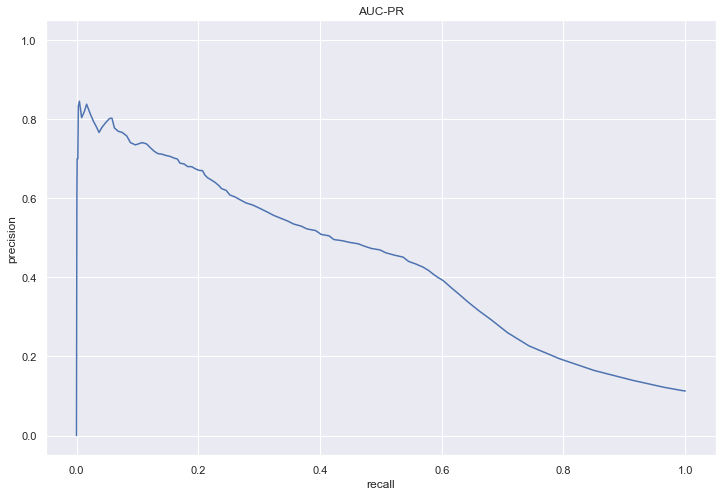

In [215]:
plt.figure(figsize=(12,8))
plt.plot(recall_treshold, precision_treshold)
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.ylabel('precision')
plt.xlabel('recall')
plt.title('AUC-PR')
plt.show()

In [221]:
recall_treshold = np.array(recall_treshold)
precision_treshold = np.array(precision_treshold)
recall_50 = recall_treshold[recall_treshold>0.5]
precision_50 = precision_treshold[recall_treshold>0.5]

In [223]:
new_recall = (recall_50-min(recall_50))/(max(recall_50)-min(recall_50))
new_precision = (precision_50-min(precision_50))/(max(precision_50)-min(precision_50))
print(f'PR-AUC: {auc(new_recall,new_precision):.5f}')

PR-AUC: 0.40408


__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__